## Gradient Boosting 모델로 유방암 진단 기계학습 시스템 만들기
---
기계학습(Machine Learning, ML)이 활용되는 분야 중 대표적인 것을 꼽자면 의료 분야를 빼놓을 수 없습니다. 실제로 많은 기계학습 알고리즘이 진단 보조, 환자 응급도 분류 등에 이용되고 있는데요, 이번에는 그런 활용 중 기초적인 기술을 한번 살펴보도록 하겠습니다.  
</p></br></br>


파이썬(Python)을 이용한다면, 유방암 조직 사진을 분석해서 암이 있는지 진단할 수 있는 모델을 만들 수 있습니다. 이런 작업은 원래 의사가 하지만, 의사도 사람인지라 사람이 일으키는 오기재 등의 문제(Human Error)를 피해갈 수 없습니다. 이런 한계를 뛰어넘기 위해 개발자들이 암 진단 모델을 개발하고 있는데요, 현재 가장 뛰어난 분류 모델은 실제로 의료계에서 이용되고 있다고 합니다.  
</p></br></br>


본 데이터에 사용된 자료는 실제 유방 조직 사진입니다. 5547장의 사진이 준비되어 있으며, 각각 50\*50px의 크기로 준비되어 있습니다. 너무 저해상도라고 생각되겠지만, 기계학습의 특성상 고해상도 이미지는 엄청난 컴퓨터 자원을 필요로 하는 것은 물론, 기계학습 모델에서 고려해야 할 요소가 많아지기 때문에, 교육용으로는 저해삳도 이미지를 먼저 사용하도록 합시다.  
</p></br></br>



In [1]:
# 패키지 및 데이터 불러오기
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
plt.rcParams['axes.unicode_minus'] = False

X = np.load('./Breast_Histology_images/X.npy')
y = np.load('./Breast_Histology_images/Y.npy')

</p></br></br>


각각의 사진은 유방암(Cancer=1)과 일반 조직(Cancer=0)으로 나뉘어져 있습니다. 이 정보를 이용해서 Gradient Boosting 모델을 이용해서 기계학습을 진행하고, 실제로 정확도가 어느정도 나오는지 확인해 보겠습니다. </p></br></br>



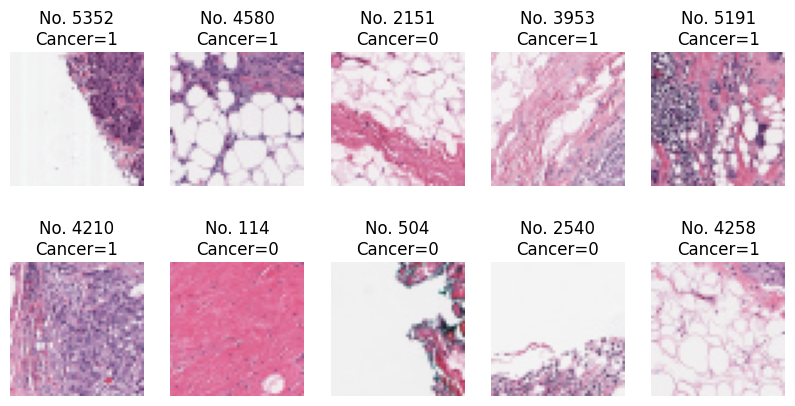

In [2]:
# 무작위 10장의 사진을 2*5 배열로 출력하기
fig, axes = plt.subplots(2, 5, figsize = (10,5))

for n,ax in enumerate(np.reshape(axes, -1)):
    i = np.random.randint(5546)
    ax.imshow(X[i])
    ax.set_title(f'No. {i}\nCancer={y[i]}')
    ax.axis('off')
    
plt.show()

</p></br></br>


### PCA
---
이번 분석에서 사용하는 사진은 50\*50\*3 배열 안에서 데이터가 표현됩니다. 이는 각각 가로 길이, 세로 길이, RGB 데이터로 이루어져 있는데, 이를 그대로 기계학습 모델에 입력할 경우 엄청난 속도 저하와 함께 정확도에도 악영향을 끼칠 수 있습니다.  
</p></br></br>


그래서, 데이터의 차원을 조절해가며 원본에서는 나타나지 않았던 특징을 찾아내는 분석을 해 보겠습니다. 이를 위해서는 주로 PCA(Principal Component Analysis, 주성분 분석) 이라는 기법이 사용되는데, 이는 고차원 데이터 집합을 가장 비슷한 하위 차원으로 변환하는 차원 축소법의 일종입니다.  
</p></br></br>


아래 코드를 사용하면, 유방암 조직 데이터에서 이미지를 구성하는 50\*50\*3개 요소를 단 두개로 축소시킬 수 있습니다.  
</p></br></br>



In [3]:
# X의 형태를 5547*50*50*3에서 5547*7500의 2차원 배열로 변환
X_reshape = np.reshape(X, (X.shape[0], X.shape[1] * X.shape[2] * X.shape[3]))

# X_reshape의 요소를 2개로 감소시키는 PCA
pca = PCA(n_components = 2)
X_reshape_pca = pca.fit_transform(X_reshape)
X_reshape_pca.shape

(5547, 2)

In [4]:
# PCA1, PCA2, class(암 발병 여부)로 구성된 dataframe 제작
df_pca = pd.DataFrame(data = X_reshape_pca, columns = ['PCA1', 'PCA2'])
df_pca['class'] = y

</p></br></br>


이렇게 차원 축소가 된 데이터는 연산량이 줄어든다는 이점도 있지만, 고차원 데이터를 낮은 차원으로 축소해 놓았기 때문에 기존에는 볼 수 없었던 데이터들의 직관적인 차이점을 눈으로 관찰할 수 있다는 장점도 있습니다.  
</p></br></br>



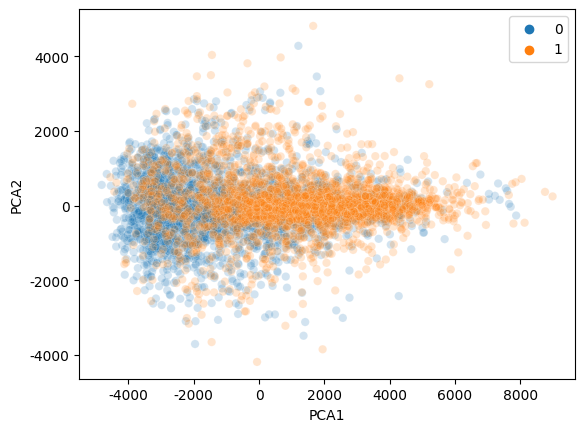

In [5]:
# 각 샘플의 비교를 다른 시각으로 할 수 있게 되었습니다
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue=df_pca['class'], alpha=0.2)
plt.legend()
plt.show()

</p></br></br>


### Gradient Boosting Model
---
Gradient Boosting 모델은 결정 트리 학습법의 일종인 부스트 트리입니다. 이 분석 모델은 기계학습 모델 중 널리 알려져 있고, 비교적 쓰기 쉬운 편인데요, 파이썬에서는 주로 사이킷런(scikit-learn) 패키지의 `GradientBoostingClassifier` 메소드를 사용하는 편입니다. 이 모델은 회귀 분석과 분류에 이용할 수 있습니다.  
</p></br></br>


Gradient Boosting 모델은 비슷한 기계학습 모델의 일종인 랜덤포레스트(Random Forest)에 비해 민감한 편이라 최적화가 힘든 편입니다. 다만, 하이퍼파라미터(Hyperparameter) 설정을 잘 한다면, 같은 조건의 랜덤포레스트 모델에 비해 더 높은 정확도를 보여주는 경향이 있다고 합니다.
</p></br></br>



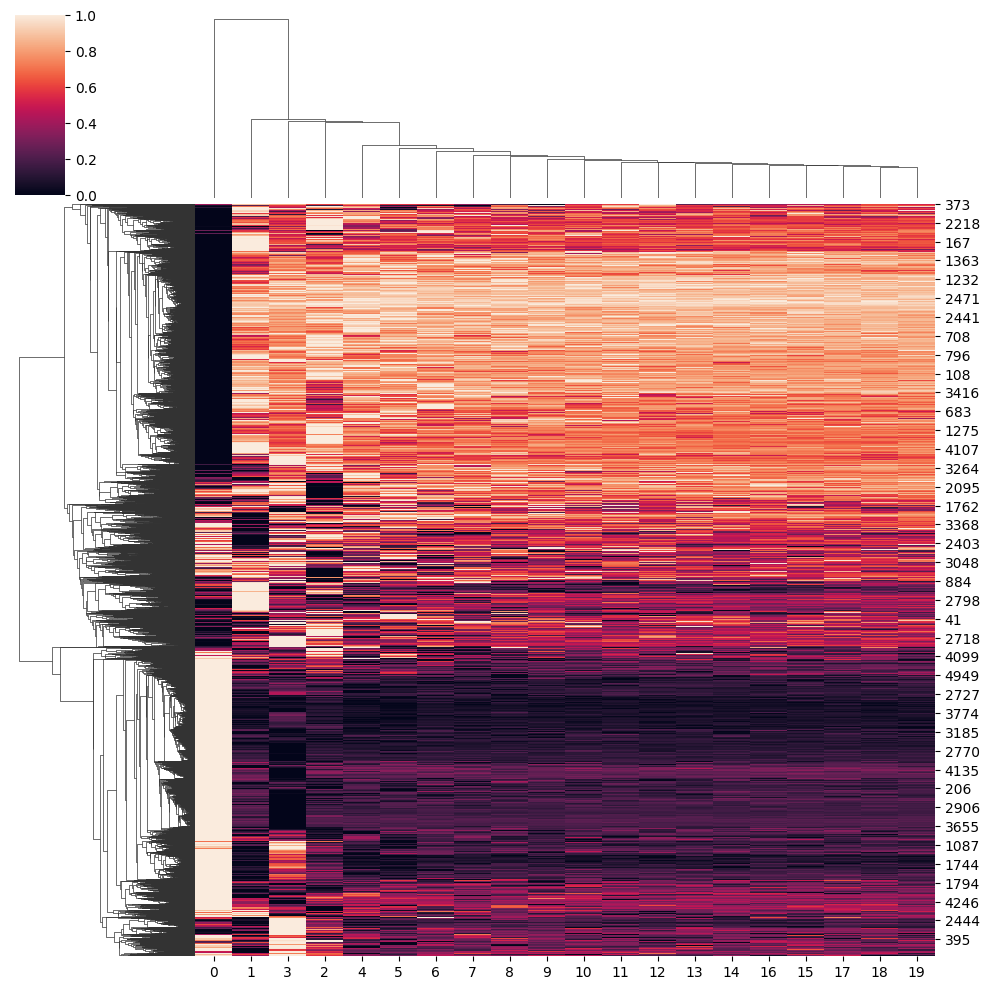

In [6]:
pca = PCA(n_components=20)  #20개 feature로 재구성하기
X_pca2 = pca.fit_transform(X_reshape)
df_X = pd.DataFrame(X_pca2)

sns.clustermap(df_X, standard_scale=0)
plt.show()

</p></br></br>


위 클러스터맵(Clustermap)을 보면, 비슷한 경향을 보여주는 Feature 다수와, 경향성이 다른 Feature 일부가 눈에 띕니다. 이렇게 특정한 패턴이 보일 경우, 분류 작업을 하기 적합한 데이터라고 예상할 수 있습니다.  
</p></br></br>


기계학습을 위해서는, 주어진 데이터를 **Train set, Test set** 으로 분류해야 합니다. 전자는 학습에 직접적으로 사용되는 데이터이며, 후자는 Train set을 이용해 학습된 모델에 별도의 데이터인 Test set을 이용해 검증을 하기 위한 용도로 이용합니다. 사이킷런의 경우, 추상화가 잘 되어 있기 때문에 `GradientBoostingClassifier` 의 `fit` 함수를 이용해 학습을 진행해 주면 됩니다.  
</p></br></br>



In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_pca2,y)

gb = GradientBoostingClassifier(n_estimators=1000, max_depth=3, learning_rate=0.1)
gb.fit(X_train,y_train)

GradientBoostingClassifier(n_estimators=1000)

</p></br></br>


기계학습 모델에서는 단순히 정확도가 높다고 좋은 결과가 아닙니다. 어떤 데이터에서 정확도가 높은지, 정밀도나 특이도는 어떤지 등을 종합적으로 판단해야 하는데요, 본 문서에서는 Train set에서의 정확도와 Test set에서의 정확도를 종합적으로 고려해 과적합(overfitting)이 일어났는지를 가늠해 보는 방식을 이용해 보도록 하겠습니다. 과적합이란, 너무 Train set에 특이적으로 기계학습 모델이 학습한 나머지, 다른 데이터에 대해서는 오히려 정확도가 크게 떨어지는 현상으로, 과적합이 일어나는 상황에서는 기계학습이 정상적으로 일어나지 않은 것으로 간주할 수 있습니다.  
</p></br></br>



In [9]:
gb.score(X_train, y_train) #train set에서의 정확도

0.9858173076923077

In [10]:
gb.score(X_test,y_test)    #test set에서의 정확도

0.768565248738284

</p></br></br>


이번에 실행한 기계학습 모델의 경우, Train set에서는 정확도가 99% 수준으로 높게 나타나지만, Test set에서는 77% 수준으로 비교적 낮은 것을 확인할 수 있습니다. 이 때는 과적합이 일어난 것으로 간주할 수 있는데, 과적합은 학습 수준을 낮추거나 데이터 전처리 방식을 바꾸는 등의 조치를 통해 개선할 수 있습니다.  
</p></br></br>



Text(0, 0.5, 'Feature importances')

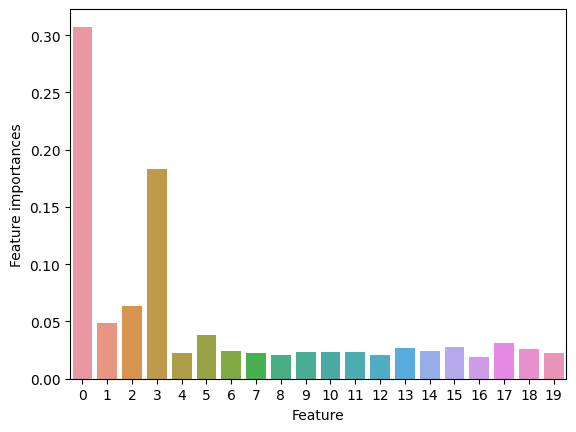

In [15]:
#feature importances를 그래프로 표시
index = df_X.columns.values

sns.barplot(x=index, y=gb.feature_importances_)
plt.xlabel('Feature')
plt.ylabel('Feature importances')

</p></br></br>


과적합이 일어난 경우, 어떤 Feature가 파이썬의 기계학습 과정에서 큰(또는 작은) 영향을 끼쳤는지를 확인해 이를 조절하는 방식으로 정확도를 개선할 수 있습니다. 이 때 고려해야 할 대상이 Feature Importance라는 요소인데요, 이는 문자 그대로 학습 요소에서 중요도를 파악할 수 있는 지표입니다. 이 모델에서는 0번과 3번 Feature가 특히 큰 영향을 끼쳤고, 4번이나 16번 Feature는 상대적으로 중요도가 떨어지는 것으로 나타납니다. 이 요소의 Feature Importance가 달라지는 방향으로 데이터를 조절하거나, 지나치게 Feature Importance가 크거나 낮은 Feature를 제거하는 방식을 고려해볼 수 있습니다.  